In [23]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import TwoSlopeNorm
import warnings
import numpy as np
import pandas as pd
import regex as re
import copy
import pickle
import community
import seaborn as sns
import os
import ast
from collections import defaultdict

DATA_PATH = 'data/'

# Preprocessing

# Preprocess the two book dataframes
- Load dataframes ('https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home', 'https://github.com/malcolmosh/goodbooks-10k-extended/blob/master/README.md')
- Remove faulty elements of dataframe without the descriptions
- Remove "additions" to titles in the description dataframes - Example: title (series #1) -> title
- Make a new dataframe that contains "Book ID" (from the dataframe without descriptions), "Book Title" (-||-), "genre" (description dataframe), "description" (description dataframe)
- Store this dataframe

In [16]:
# Load dataframes
descriptions_df = pd.read_csv(DATA_PATH + "books_descriptions.csv")
book_ID_df = pd.read_json(DATA_PATH + 'goodreads_book_works.json', lines=True)

# Remove columns that are not needed in book_ID_df
book_ID_df = book_ID_df.filter(items=["best_book_id", "original_title", "reviews_count"])


In [17]:
# List amount of books are in each dataframe
print(f"Amount of books in descriptions_df: {len(descriptions_df)}")
print(f"Amount of books in book_ID_df: {len(book_ID_df)}")

Amount of books in descriptions_df: 10000
Amount of books in book_ID_df: 1521962


In [18]:
# Remove faulty elements from the description dataframe
full_descriptions_df_size = len(descriptions_df)
descriptions_df = descriptions_df[descriptions_df['description'].apply(lambda x: isinstance(x, str))]

print(f"Amount of books in descriptions_df: {len(descriptions_df)}. \nAmount of elements removed: {full_descriptions_df_size - len(descriptions_df)}")

# Remove faulty elements from the book_ID_df
full_book_ID_df_size = len(book_ID_df)
book_ID_df = book_ID_df[book_ID_df['original_title'] != '']

print(f"Amount of books in book_ID_df: {len(book_ID_df)}. \nAmount of elements removed: {full_book_ID_df_size - len(book_ID_df)}")

Amount of books in descriptions_df: 9943. 
Amount of elements removed: 57
Amount of books in book_ID_df: 646906. 
Amount of elements removed: 875056


In [19]:
# Remove "additions" to titles in the descriptions_df
for i, row in tqdm(descriptions_df.iterrows(), total = len(descriptions_df)):
    original_title = row["title"]
    new_title = re.sub(r'\((.*)', '', original_title)
    descriptions_df.at[i, "title"] = new_title.strip()

9943it [00:00, 21072.02it/s]


In [20]:
# Lower case all titles to not have confusion in this manner
descriptions_df['title'] = descriptions_df['title'].str.lower()
book_ID_df['original_title'] = book_ID_df['original_title'].str.lower()

In [ ]:
# Find corresponding indexes to merge the dataframes
warnings.simplefilter(action='ignore', category=FutureWarning)
titles_not_found = []
book_df = pd.DataFrame(columns=['book_id', 'title', 'description', 'genres'])

for i, row in tqdm(descriptions_df.iterrows(), total = descriptions_df.shape[0]):
    title = row['title']
    # Check if the title is in book_ID_df, else append it to the titles_not_found list
    if title in book_ID_df['original_title'].values:
        # Get all rows that have the a matching title as the current row
        temp_df = book_ID_df[book_ID_df['original_title'] == title]

        # Get the book id of the book  with the highest amount of reviews
        book_id = temp_df['best_book_id'][temp_df['reviews_count'].idxmax()]
        descriptions = row['description']
        genres = row['genres']
        book_df = book_df.append({'book_id': book_id, 'title': title, 'description': descriptions, 'genres': genres}, ignore_index=True)
    else:
        titles_not_found.append(title)

# print the amount of elements that are not found
print(f"Out of the 10000 titles {len(titles_not_found)} are not found in the book_ID_df")

# Somehow the same book appears multiple times, hence we drop the duplicates
book_df.drop_duplicates(subset=['title'], inplace=True)
print()

# Preprocess the shelves
- Use "book_id_map.csv" to find the books we use (ids) and store "new_ids" (the ids we can use to find the relevant shelfs)
- Drop all rows in "goodreads_interactions.csv" that have different ids than "new_ids".
- Store this dataset.

In [2]:
# Load dataframes
book_id_map_df = pd.read_csv(DATA_PATH + "book_id_map.csv")
book_df = pd.read_csv(DATA_PATH + "book_df.csv")

In [ ]:
# Create map from book_id to book_id_csv
book_id_map = {book_id_map_df['book_id'][i]: book_id_map_df['book_id_csv'][i] for i in range(len(book_id_map_df))}

# Change the book ID in our dataset to match the shelf dataset
remove_list = [] # remove about 15 books that are for inexplicable reasons not in the shelf dataset
for i in range(len(book_df)):
    try:
        book_df["book_id"][i] = book_id_map[book_df["book_id"][i]]
    except:
        remove_list.append(i)
print(f"Out of {i} books {len(remove_list)} are not in the shelf dataset and hence removed")
book_df.drop(remove_list, inplace=True)

# Save the book_df dataframe with the index change
book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)

In [ ]:
# Load the shelves dataframe (this takes some time and memory)
shelves_df = pd.read_csv(DATA_PATH + "goodreads_interactions.csv")

# Check how many books are on the shelves of ALL users combined
print(f'There are {len(shelves_df)} books, copies counted aswell')

In [ ]:
# Remove books on the shelves that are not in the book_df
shelves_df = shelves_df[shelves_df['book_id'].isin(book_df['book_id'].tolist())]

# Save the new shelves_df
shelves_df.to_csv(DATA_PATH + 'shelves_df.csv', index=False)

# Check how many books are on the shelves of ALL users combined - after removal of books not in book_df
print(f"We have {len(shelves_df)} shelves in total, and in these there are {len(set(shelves_df['book_id'].tolist()))} unique books.")

# TF-IDF embeddings
- Create TF-IDF embeddings
- Create them for genres aswell

In [ ]:
# imports for the text analysis
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import ast

# Import the book description dataframe
book_df = pd.read_csv(DATA_PATH + "book_matching_ids_df.csv") # TODO help me not make a "Unnamed: 0" column... I want to use the book_id as index, but then it creates this column

# Logorithmic scale chosen for IDF
BASE = 2

In [2]:
# Function to clean strings (from week 7)
def clean_strings(strings):
    """ Cleans a list of strings by removing URLs, numbers, punctuation and stop words

    Args:
    - strings: a list of strings

    returns:
    - cleaned_strings: a list of cleaned strings
    """
    cleaned_strings = []
    stop_words = set(stopwords.words('english'))

    for string in strings:
        # Remove URLs
        string = re.sub(r'http\S+', '', string)

        # Remove numbers
        string = re.sub(r'[0-9]', '', string)

        # Keep only what is not punctuation
        string = re.sub(r'[^\w\s]', '', string)

        # Lowercase
        string = string.lower()

        # Remove empty strings and remove stop words and moke them
        if len(string) and string not in stop_words and type(string) == str:
            cleaned_strings.append(string)

    return cleaned_strings


In [ ]:
# Create tokens from descriptions
# If the dataframe has not yet gotten the tokens, do it here and save it
if not 'tokens' in book_df.columns:
    book_df['tokens'] = None
    for i, row in tqdm(book_df.iterrows(), total = book_df.shape[0]):
        description = row['description']
        # If the description is not a string, it is probably a NaN, so we set it to None
        if type(description) == str:
            tokens = nltk.word_tokenize(description)
            clean_tokens = clean_strings(tokens)
            book_df['tokens'][i] = clean_tokens # str(clean_tokens)

    book_df.to_csv(DATA_PATH + 'book_matching_ids_df.csv', index=False)
else:
    book_df['tokens'] = book_df['tokens'].apply(ast.literal_eval)

In [ ]:
# Calculate the tf scores for each community (from the previous weeks)
def TF_from_corpus(corpus):
    """ Calculates the TF scores for each word in the corpus

    Args:
        corpus (list): list of lists of words/strings

    Returns:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
    """
    # Create empty dictionary to keep track of word counts
    word_counts = {}
    n_communities = len(corpus)

    # Iterate through all communities
    for i, document in tqdm(enumerate(corpus), total=n_communities):
        # Iterate through each word in the current sublist
        for word in document:
            # If the current word is not in the dictionary, add it with a list of zeros
            if word not in word_counts:
                word_counts[word] = [0] * n_communities

            # Increment count for the current word and list index
            word_counts[word][i] += 1

    # Create pandas dataframe from the word_counts dictionary
    TF_df = pd.DataFrame.from_dict(word_counts).transpose()

    return TF_df

In [ ]:
# Function that takes in a TF and an IDF and computes the TF_IDF dataframe (from the previous weeks)
def make_TF_IDF(TF_df, IDF_dict):
    """Multiply the TF and IDF scores to get the TF-IDF scores

    Args:
        TF_df (pandas.DataFrame): Dataframe containing the TF scores for each word in the corpus
        IDF_dict (dict): Dictionary containing the IDF scores for each word in the corpus

    Returns:
        TF_IDF (pandas.DataFrame): Dataframe containing the TF-IDF scores for each word in the corpus
    """
    # Create the TF-IDF dataframe
    TF_IDF = pd.DataFrame(index=TF_df.index, columns=TF_df.columns)

    # iterate over the index of the DataFrame
    for word in tqdm(TF_df.index, total=TF_df.shape[0]):
        # multiply the values by the IDF_dict value
        TF_IDF.loc[word] = TF_df.loc[word] * IDF_dict[word]


    return TF_IDF

In [ ]:
# Load the TF dataframe for the corpus if possible, else create it
try:
    TF_book_df = pd.read_csv(DATA_PATH + "TF_book_df.csv", index_col=0)
except:
    # Create it
    TF_book_df = TF_from_corpus(book_df['tokens'])

    # Rename the columns to the book_ids
    TF_book_df.columns = book_df['book_id'].tolist()

    # Save the TF dataframe
    TF_book_df.to_csv(DATA_PATH + "TF_book_df.csv")

In [ ]:
# Create the total token count "T_all_books" and the IDF score for each book "IDF_book_dict"
try:
    IDF_dict = np.load(DATA_PATH + 'IDF_dict.npy', allow_pickle=True).item()
except:
    T_all_books = TF_book_df.apply(lambda row: (row != 0).sum(), axis=1)
    # The log BASE is chosen when loading the libraries
    IDF_dict = {word: np.emath.logn(BASE, len(TF_book_df.columns)/ T_all_books[word]) for word in TF_book_df.index}

    np.save(DATA_PATH + 'IDF_dict.npy', IDF_dict)

In [ ]:
# Create the TF-IDF scores for each book "TF_IDF_book_df" if it has not already been made
try:
    TF_IDF_book_df = pd.read_csv(DATA_PATH + "TF_IDF_book_df.csv", index_col=0)
except:
    # Create the dataframe
    TF_IDF_book_df = make_TF_IDF(TF_book_df, IDF_dict)

    # Save the dataframe
    TF_IDF_book_df.to_csv(DATA_PATH + "TF_IDF_book_df.csv")

#### Genre TF and TF_IDF scores
- Do this by having all books with a genre define the "document" for that genre
- Then compute the "TF_genre_df" dataframe, by summing all books from "TF_book_df" from that genre
- Here we make the decision that the IDF is the same as for the books.
    - (Alternatively one could have weighed each book and made a new IDF score, however, this weighs a book with twice as many genres twice as large, hence we use the other option)

In [ ]:
# Find the set of genres
genres = set()
for i in book_df["genres"].to_list():
    genres = genres.union(set(ast.literal_eval(i)))

In [ ]:
# Try to load the TF_genres_df, else create it
try:
    # Load the TF_genres_df
    TF_genres_df = pd.read_csv(DATA_PATH + "TF_genres_df.csv", index_col=0)
except:
    # For each genre, sum all TF scores for books in that genre
    TF_genres_df = pd.DataFrame(index=TF_book_df.index, columns=genres)

    TF_genres_df = TF_genres_df.fillna(0)

    # Go through all books and add the TF scores to the genres of the book
    for i, row in tqdm(book_df.iterrows()):
        for genre in ast.literal_eval(row['genres']):
            TF_genres_df[genre] = TF_genres_df[genre] + TF_book_df[row['book_id']]

    # Save the genres_TF_df
    TF_genres_df.to_csv(DATA_PATH + "TF_genres_df.csv")

In [ ]:
# Try to load the TF_IDF_genres_df, else create it
try:
    # Load the TF_IDF_genres_df
    TF_IDF_genres_df = pd.read_csv(DATA_PATH + "TF_IDF_genres_df.csv", index_col=0)
except:
    # Create the dataframe
    TF_IDF_genres_df = make_TF_IDF(TF_genres_df, IDF_dict)

    # Save the dataframe
    TF_IDF_genres_df.to_csv(DATA_PATH + "TF_IDF_genres_df.csv")

In [3]:
# Have not added things with # delete

# Create a genre for each book
- make the inner product which each book and the genre vector (both normed)
- let the largest inner product that the book contains be the genre of the book

In [4]:
# Inner product function
def inner_product(v1, v2):
    """Calculates the normed inner product of two vectors

    Args:
        v1 (list): list of numbers
        v2 (list): list of numbers

    Returns:
        inner_product (float): inner product of the two vectors (divided by the product of their norms)
    """

    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [5]:
# Generate genre by taking inner products between each book and each genre of that book, and choosing the maximal
def get_genres(book_df, TF_IDF_genres_df, TF_IDF_book_df):
    # TODO: Check these args and return
    """
    Args:
        book_df (DataFrame): DataFrame with genres for each book
        TF_IDF_genres_df (DataFrame): DataFrame with TF_IDF each genre
        TF_IDF_book_df (DataFrame): DataFrame with TF_IDF each book

    Returns:
        genres (dict): Dictionary with book ids as keys and the corresponding gerne that matches the best
    """

    # Create a dictionary to store the genre for each book
    genres = {}

    # Go through each book
    for i, row in tqdm(book_df.iterrows()):
        # Get the TF-IDF scores for the current book
        book_TF_IDF = TF_IDF_book_df[row["book_id"]]

        best_genre = (None, 0)

        # Go through each genre of the book
        for genre in ast.literal_eval(row['genres']):
            genre_TF_IDF = TF_IDF_genres_df[genre]
            # print(f"inner_product {inner_product(book_TF_IDF, genre_TF_IDF)} {genre}") # Testing
            if inner_product(book_TF_IDF, genre_TF_IDF) > best_genre[1]:
                best_genre = (genre, inner_product(book_TF_IDF, genre_TF_IDF))
        # print(best_genre) # Testing
        # break # Testing
        # Save the best genre
        genres[row["book_id"]] = best_genre[0]

    return genres

In [ ]:
# Get the genres for each book
genres = get_genres(book_df, TF_IDF_genres_df, TF_IDF_book_df)

book_df["top_genre"] = book_df["book_id"].map(genres)


In [ ]:
# Save the book_df as complete_book_df
book_df.to_csv(DATA_PATH + "complete_book_df.csv")

# Analysis
Choosing a threshold for the graph

In [ ]:
# Create the shelf edges and store them (this takes about 12 hours)
shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
# Collapse into shelves
imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

# Count occurrences of each book
book_counts = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    for book in shelf['book_id']:
        if book in book_counts:
            book_counts[book] += 1
        else:
            book_counts[book] = 1

# Count appearances of pairs of books
edges = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    if len(shelf['book_id']) > 1:
        # Generate pairs of books
        for i in range(len(shelf['book_id'])):
            for j in range(i+1, len(shelf['book_id'])):
                # Create edge
                edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                # Add edge to dictionary
                if edge in edges:
                    edges[edge] += 1
                else:
                    edges[edge] = 1


In [28]:
# load data
if 'shelves_df' not in locals():
    shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')

In [29]:
# Implode dataframe to get books for each user in a list for each
imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()
print(f'The amount of users are: {len(imploded_df)}')

The amount of users are: 818569


In [30]:
#Get all the edges:
edges_orginal = np.load(DATA_PATH + "shelf_edges.npy", allow_pickle=True).item()
print(f'In the full network there are {len(edges_orginal)} edges')

In the full network there are 28704535 edges


In [ ]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges_orginal.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [ ]:
#TODO: That amount of edges is way to much comment

### See what thresholds would be better

In [31]:
edges_weighted = edges_orginal.copy()

In [ ]:
#TODO comment on the method for weighting the edges

In [32]:
# Count occurrences of each book
book_counts = {}
for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
    for book in shelf['book_id']:
        if book in book_counts:
            book_counts[book] += 1
        else:
            book_counts[book] = 1

100%|██████████| 818569/818569 [00:43<00:00, 18751.65it/s]


In [33]:
#For each edge divide the weight of it by the lowest appearence count of the two nodes it connects
for edge in tqdm(edges_weighted):
            edges_weighted[edge] = edges_weighted[edge] / min((book_counts[list(edge)[0]], book_counts[list(edge)[1]]))

100%|██████████| 28704535/28704535 [00:27<00:00, 1050938.81it/s]


In [34]:
# Save weighted edges
np.save(DATA_PATH + 'shelf_edges_weighted.npy', edges_weighted)

In [ ]:
# Plot a histogram of the number of times each edge appears
plt.hist(edges_weighted.values(), log=True, bins=100)
# plt.xscale('log')
plt.xlabel('People who had booth books')
plt.ylabel('Count')
plt.title('Distribution of books appearing together')
plt.show()

In [ ]:
threshold = 0.1
while threshold <= 0.8:
    edges_threshold = {k: v for k, v in edges_weighted.items() if v >= threshold}

    nodes = {node for nodes in edges_threshold for node in nodes}

    print(f'For the threshold of {np.round(threshold,2)}:')
    print(f'The amount of edges is {len(edges_threshold)}, nodes: {len(nodes)} and the node/edges fraction is: {len(edges_threshold)*2/len(nodes)}')
    print()
    threshold += 0.1

In [ ]:
#Todo: Snak om overvejelserne her
# tager 0.5

# Create network
- Load dataframe with shelves
- Implode dataframe to make shelves into edgelist
- Calculate assortativity
    - Genre
    - Degrees
- Get largest sub network
- Create communities
    - Color according to genre

In [91]:
# Create the network
#TODO: Jeg har ændre på den
def create_network(threshold=0.5):
    """
    Creates the network from the shelf edges.
    If the edges have already been created, they are loaded.
    Otherwise, they are created and stored. The edges are filtered by the threshhold. The network is returned.

    Args:
        threshhold (int): The minimum number of times an edge must appear to be included in the network.

    Returns:
        G (networkx.Graph): The network of book edges.
    """
    # If the edges have already been created, load them
    try:
        # Load the shelf edges
        edges = np.load(DATA_PATH + 'edges_weighted.npy', allow_pickle=True).item() # (takes about 10 minutes)
        print('Loaded weighted edges')
    except:

        # Create the shelf edges and store them (this takes about 12 hours)
        shelves_df = pd.read_csv(DATA_PATH + 'shelves_df.csv')
        # Collapse into shelves
        imploded_df = shelves_df.groupby('user_id')['book_id'].apply(list).reset_index()

        # Count occurrences of each book
        book_counts = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            for book in shelf['book_id']:
                if book in book_counts:
                    book_counts[book] += 1
                else:
                    book_counts[book] = 1

        # Count appearances of pairs of books
        edges = {}
        for i, shelf in tqdm(imploded_df.iterrows(), total=imploded_df.shape[0]):
            if len(shelf['book_id']) > 1:
                # Generate pairs of books
                for i in range(len(shelf['book_id'])):
                    for j in range(i+1, len(shelf['book_id'])):
                        # Create edge
                        edge = frozenset([shelf['book_id'][i], shelf['book_id'][j]])
                        # Add edge to dictionary
                        if edge in edges:
                            edges[edge] += 1
                        else:
                            edges[edge] = 1

        # Weigh edges by dividing the count by the lowest amount of appearances between the two books
        for edge in edges:
            edges[edge] = edges[edge] / min(book_counts[list(edge)[0]], book_counts[list(edge)[1]])

        # Store the edges
        np.save(DATA_PATH + 'edges_weighted.npy', edges)

    print('Starting to create edges')

    # Remove edges that are below the threshhold
    edges = {k: v for k, v in tqdm(edges.items()) if v >= threshold}

    # Create the network
    G = nx.Graph()
    G.add_weighted_edges_from(([(u, v, w) for (u, v), w in edges.items()]))

    return G


In [25]:
if not "complete_book_df" in locals():
    complete_book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

In [93]:
# Give nodes attributes
def make_attributes(df, graph):
    #TODO: args and returns
    # make a dictionary with attributes for each node
    book_attributes = dict()
    for i, book in tqdm(df.iterrows(), total=df.shape[0]):
        node = book['book_id']
        if not node in graph.nodes():
            continue
        book_attributes[node] = dict()
        top_genre = book['top_genre']
        title = book['title']
        genres = eval(book['genres'])

        book_attributes[node]['title'] = title
        book_attributes[node]['genres'] = genres
        book_attributes[node]['top_genre'] = top_genre
    return book_attributes

In [94]:
folder_path = DATA_PATH
file_name = "shelves_network_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Make the network
    shelf_graph = create_network(0.5)

    #Give nodes attributes
    shelf_attribute_dict = make_attributes(complete_book_df, shelf_graph)
    nx.set_node_attributes(shelf_graph, shelf_attribute_dict)

    # Save the network
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(shelf_graph, f)

Loaded weighted edges
Starting to create edges


100%|██████████| 7676/7676 [00:00<00:00, 18245.82it/s]


In [95]:
print(shelf_graph)

Graph with 7539 nodes and 109627 edges


## Create NLP network

In [96]:
# Used to make all node ids ints
def make_all_nodes_ints(graph):
    #TODO: args and returns

    # Check if first id is a string, in which case, don't do anyting
    if isinstance(list(graph.nodes())[0], int):
            return graph

    # Make a mapping so each node can be renamed into what it was, but a string instead
    node_map = {}
    for node in graph.nodes():
        node_map[node] = int(node)
    str_graph = nx.relabel_nodes(graph, node_map)

    return str_graph

In [97]:
if 'shelf_graph' not in locals():
    with open(DATA_PATH + 'shelves_network_05.pickle', 'rb') as f:
        shelf_graph = pickle.load(f)
        shelf_graph = make_all_nodes_ints(shelf_graph)

In [98]:
#TODO: Comment on how we make the NLP network (Inner products)

In [99]:
# Load the TF_IDF values for each book
tf_idf_book = pd.read_csv(DATA_PATH + "TF_IDF_book_df.csv", index_col=0)
book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv", index_col=0)

KeyboardInterrupt: 

In [100]:
# Inner product function
def inner_product(v1, v2):
    """Calculates the normed inner product of two vectors

    Args:
        v1 (list): list of numbers
        v2 (list): list of numbers

    Returns:
        inner_product (float): inner product of the two vectors (divided by the product of their norms)
    """

    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [101]:
# Create the inner product between every book
try:
    NLP_edges = np.load(DATA_PATH + 'NLP_edges.npy', allow_pickle=True).item()
    print('Edges were loaded')
except:
    similarities = {}
    for i in tqdm(range(len(book_df))):
        for j in range(i+1, len(book_df)):
            similarities[(book_df.iloc[i]["book_id"], book_df.iloc[j]["book_id"])] = inner_product(tf_idf_book[str(book_df.iloc[i]["book_id"])], tf_idf_book[str(book_df.iloc[j]["book_id"])])

    # Save the edges
    np.save(DATA_PATH + 'NLP_edges.npy', similarities)
    NLP_edges = similarities
    print('Edges were saved')

Edges were loaded


In [102]:
# Find the value that separates the top 256679 larges edges from the rest
threshold = sorted(NLP_edges.values(), reverse=True)[shelf_graph.number_of_edges()]
print(f'The threshold to have the same number of edges in the NLP as the shelf graph is: {np.round(threshold,3)}')

The threshold to have the same number of edges in the NLP as the shelf graph is: 0.056


In [103]:
NLP_edges = {k: v for k, v in NLP_edges.items() if v >= threshold}

In [104]:
NLP_graph = nx.Graph()
NLP_graph.add_weighted_edges_from(([(u, v, w) for (u, v), w in NLP_edges.items()]))
print(NLP_graph)

Graph with 7661 nodes and 109628 edges


In [105]:
if not "complete_book_df" in locals():
    complete_book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

In [106]:
# Give nodes attributes
NLP_attribute_dict = make_attributes(complete_book_df, NLP_graph)
nx.set_node_attributes(NLP_graph, NLP_attribute_dict)

100%|██████████| 7676/7676 [00:00<00:00, 22021.41it/s]


In [107]:
# Save NLP_graph
folder_path = DATA_PATH
file_name = "NLP_network_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Save the network
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(NLP_graph, f)

# Network analysis

### Communities

In [108]:
import community

In [109]:
# Function that applies the Louvain algorithm to a grap, and returns communities
def louvain_communities(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm

    # Reformat the partitioning
    communities = {}
    for node, community_id in partition.items():
        if community_id in communities:
            communities[community_id].append(node)
        else:
            communities[community_id] = [node]

    return list(communities.values())

def louvain_communities_faster(graph):
    # Use the louvain method to find communities
    partition = community.best_partition(graph) # community function that uses Louvain-algorithm

    # Reformat the partitioning
    communities = {}
    for node, community_id in tqdm(partition.items()):
        communities.setdefault(community_id, []).append(node)

    return list(communities.values())

In [110]:
# Save shelf_louvain_05
folder_path = DATA_PATH
file_name = "shelf_louvain_051.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Save the communities
    shelf_louvain = louvain_communities_faster(shelf_graph)
    with open(DATA_PATH + 'shelf_louvain_05.pickle', 'wb') as f:
        pickle.dump(shelf_louvain, f)
else:
    # Load the communities
    with open(DATA_PATH + 'shelf_louvain_05.pickle', 'rb') as f:
        shelf_louvain = pickle.load(f)

100%|██████████| 7539/7539 [00:00<00:00, 3755000.34it/s]


In [111]:
# Save NLP_graph
folder_path = DATA_PATH
file_name = "NLP_louvain_05.pickle"

if not os.path.exists(os.path.join(folder_path, file_name)):
    # Save the network
    NLP_louvain = louvain_communities_faster(NLP_graph)
    with open(DATA_PATH + file_name, 'wb') as f:
        pickle.dump(NLP_louvain, f)
else:
    with open(DATA_PATH + file_name, 'rb') as f:
        NLP_louvain = pickle.load(f)

100%|██████████| 7661/7661 [00:00<00:00, 3058205.29it/s]


### Modularity

In [16]:
#Modularity function
def modularity(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = {community: 0 for community in range(num_of_communities)}
    tot_degree = {community: 0 for community in range(num_of_communities)}

    # Dictionary to map node IDs to community IDs
    communities_lookup = {node: community for community, nodes in enumerate(communities) for node in nodes}

    # Count the number of links within each community and the total degree of each community
    for (node_1, node_2) in G.edges():
        node_1_community = communities_lookup[node_1]
        node_2_community = communities_lookup[node_2]

        # Since we go through all edges, we also get the degree of all nodes
        tot_degree[node_1_community] += 1
        tot_degree[node_2_community] += 1

        # If the nodes are in the same community, add one to that community's link count
        if node_1_community == node_2_community:
            links_in_community[node_1_community] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_faster(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    total_links = G.number_of_edges()
    num_of_communities = len(communities)
    links_in_community = [0] * num_of_communities
    tot_degree = [0] * num_of_communities
    nodes_in_community = [set(c) for c in communities]

    # Compute the total degree of nodes in each community
    for node, community in enumerate(nodes_in_community):
        community_edges = G.subgraph(community).edges()
        community_degree = sum([G.degree(n) for n in community])
        tot_degree[node] = community_degree
        for n1, n2 in community_edges:
            if n1 in community and n2 in community:
                links_in_community[node] += 1

    # Compute the modularity
    M = 0.0
    for i in range(num_of_communities):
        M += (links_in_community[i] / total_links) - ((tot_degree[i] / (2 * total_links)) ** 2)

    return M

def modularity_nx(G, communities):
    """
    Compute the modularity for a communities of a graph.

    Parameters:
        - G: the NetworkX graph
        - communities (list): a list of communities, where each community is a list of node IDs

    Returns:
        - M: the modularity value for the graph
    """

    # Use the louvain method to find communities
    partition = {node: community_id for community_id, nodes in enumerate(communities) for node in nodes}

    # Compute the modularity
    M = community.modularity(partition, G)

    return M


In [33]:
shelf_modularity = modularity_nx(shelf_graph,shelf_louvain)
print('The modularity of shelf graph is:', shelf_modularity)

The modularity of shelf graph is: 0.0077714398031069965


In [34]:
NLP_modularity = modularity_nx(NLP_graph,NLP_louvain)
print('The modularity of NLP graph is:', NLP_modularity)

The modularity of NLP graph is: -0.0006186792913910722


In [25]:
try:
    shelf_modularities = np.load(DATA_PATH + "shelf_modularities.npy", allow_pickle=True)
except:
    #Set seed in the interest of repeatability
    random.seed(69420)
    #A list that will contain a thousand randomized modularities
    shelf_modularities = []

    # Load the louvain groups if not in memory
    if 'shelf_louvain' not in locals():
        with open(DATA_PATH + 'shelf_louvain_05.pickle', 'rb') as f:
            shelf_louvain = pickle.load(f)

    if 'shelf_graph' not in locals():
        with open(DATA_PATH + 'shelves_network_05.pickle', 'rb') as f:
            shelf_graph = pickle.load(f)

    #The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
    #Here we use the previously defined modularity and edge_swap functions
    for i in tqdm(range(100)):
        shelf_rand = nx.double_edge_swap(shelf_graph, nswap=len(shelf_graph.edges()) + 1000, max_tries=(len(shelf_graph.edges()) + 1000) * 10)
        shelf_modularities.append(modularity_nx(shelf_rand, shelf_louvain))

    # Save the date
    np.save(DATA_PATH + "shelf_modularities.npy", shelf_modularities)

100%|██████████| 100/100 [10:13<00:00,  6.13s/it]


In [26]:
try:
    NLP_modularities = np.load(DATA_PATH + "NLP_modularities.npy", allow_pickle=True)
except:
    #Set seed in the interest of repeatability
    random.seed(69420)
    #A list that will contain a thousand randomized modularities
    NLP_modularities = []

    # Load the louvain groups if not in memory
    if 'NLP_louvain' not in locals():
        with open(DATA_PATH + 'NLP_louvain_05.pickle', 'rb') as f:
            NLP_louvain = pickle.load(f)

    if 'NLP_graph' not in locals():
        with open(DATA_PATH + 'NLP_network_05.pickle', 'rb') as f:
            NLP_graph = pickle.load(f)

    #The loop that produces a thousand edge swapped datasets, and appends them to rand_modularities
    #Here we use the previously defined modularity and edge_swap functions
    for i in tqdm(range(200)):
        NLP_rand = nx.double_edge_swap(NLP_graph, nswap=len(NLP_graph.edges()) + 1000, max_tries=(len(NLP_graph.edges()) + 1000) * 10)
        NLP_modularities.append(modularity_nx(NLP_rand, NLP_louvain))

    # Save the date
    np.save(DATA_PATH + "NLP_modularities.npy", NLP_modularities)



100%|██████████| 200/200 [14:13<00:00,  4.27s/it]


In [35]:
shelf_mean_rand_mods = np.mean(shelf_modularities)
shelf_std_rand_mods = np.std(shelf_modularities)

NLP_mean_rand_mods = np.mean(NLP_modularities)
NLP_std_rand_mods = np.std(NLP_modularities)

print(f"(Shelf) The mean of the {len(shelf_graph.edges()) + 1000} edge swapped modularities is " + str(np.round(shelf_mean_rand_mods, 5)))
print(f"(Shelf) The standard deviation of the {len(shelf_graph.edges()) + 1000} edge swapped modularities is " + str(np.round(shelf_std_rand_mods, 5)))

print()

print("(NLP) The mean of the thousand edge swapped modularities is " + str(np.round(NLP_mean_rand_mods, 5)))
print("(NLP) The standard deviation of the thousand edge swapped modularities is " + str(np.round(NLP_std_rand_mods, 5)))

(Shelf) The mean of the 110627 edge swapped modularities is 0.00776
(Shelf) The standard deviation of the 110627 edge swapped modularities is 0.0009

(NLP) The mean of the thousand edge swapped modularities is -0.00021
(NLP) The standard deviation of the thousand edge swapped modularities is 0.00056


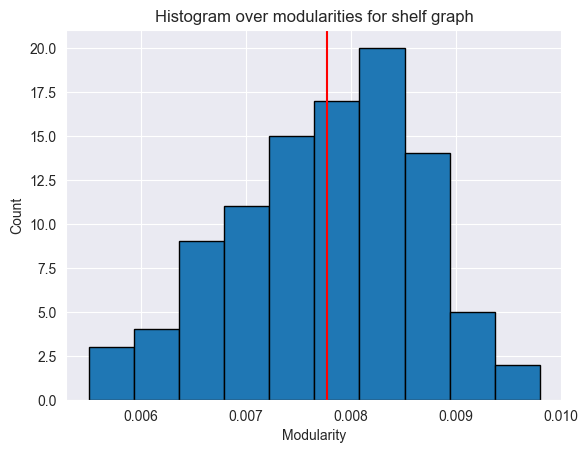

In [36]:
# Plotting a histogram over the distribution values for

plt.hist(shelf_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities for shelf graph')
plt.axvline(x=shelf_modularity, color = "red")
plt.show()

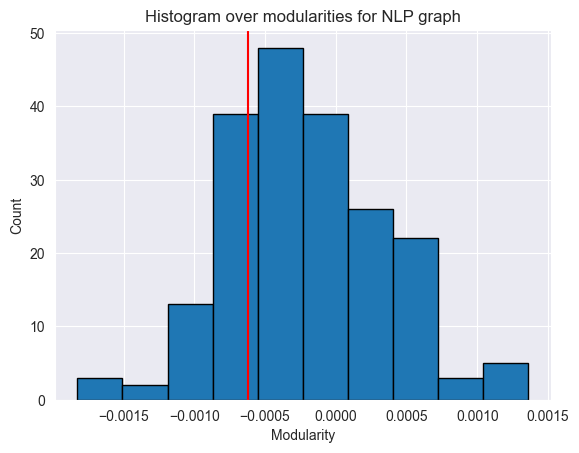

In [38]:
# Plotting a histogram over the distribution values for

plt.hist(NLP_modularities, edgecolor='black')
plt.xlabel('Modularity')
plt.ylabel('Count')
plt.title('Histogram over modularities for NLP graph')
plt.axvline(x=NLP_modularity, color = "red")
plt.show()

### Confusion matricies

In [36]:
def create_matching_matrix(graph1, graph2):
    graph1_groups = list(set(graph1.values()))
    graph2_groups = list(set(graph2.values()))

    matrix = defaultdict(lambda: defaultdict(int))
    for group1 in graph1_groups:
        for group2 in graph2_groups:
            matrix[group1][group2] = 0

    for book_id, group1 in graph1.items():
        group2 = graph2.get(book_id)
        if group2 is not None:
            matrix[group1][group2] += 1

    df = pd.DataFrame(matrix).T.fillna(0)
    return df

In [46]:
 def plot_matching_matrix(matching_matrix, title='Matching Matrix', xlabel=None, ylabel=None,size_title = 20):
    n_columns = len(matching_matrix.columns)

    # Sort rows by their sum in descending order
    matching_matrix = matching_matrix.loc[matching_matrix.sum(axis=1).sort_values(ascending=False).index]

    # Adjust the figsize to create square cells
    fig, ax = plt.subplots(figsize=(n_columns, n_columns))

    sns.set(font_scale=1.2, rc={"axes.grid": False})

    cmap = sns.color_palette("rocket_r", as_cmap=True)

    image_data = np.zeros((len(matching_matrix), n_columns, 4))

    for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):
        # Change the vmax to the sum of all the numbers in the column
        norm = TwoSlopeNorm(vmin=0, vcenter=col_data.mean(), vmax=col_data.sum())

        image_data[:, i] = cmap(norm(col_data.values))[:, :4]

        for y, value in enumerate(col_data):
            ax.text(i, y, f'{value:.0f}', ha='center', va='center', color='black' if norm(value) < 0.5 else 'white',fontsize = 30)

    # Set the aspect ratio to 1
    ax.imshow(image_data, aspect=1, interpolation='nearest')

    ax.set_xticks(range(n_columns))
    ax.set_xticklabels(matching_matrix.columns)
    ax.set_yticks(range(len(matching_matrix)))
    ax.set_yticklabels(matching_matrix.index)

    # Set the custom title, x-axis label, and y-axis label
    ax.set_title(title,fontsize = size_title)
    ax.set_xlabel(xlabel,fontsize = size_title)
    ax.set_ylabel(ylabel,fontsize = size_title)

    fig.tight_layout()
    plt.show()

In [47]:
# Getting our three communities to compare them
if not 'complete_book_df' in locals():
    complete_book_df = pd.read_csv(DATA_PATH+ "complete_book_df.csv")
book_genre_dict = complete_book_df.set_index('book_id')['top_genre'].to_dict()#.apply(lambda x: [x]).to_dict()

if 'NLP_louvain' not in locals():
        with open(DATA_PATH + 'NLP_louvain_05.pickle', 'rb') as f:
            NLP_louvain = pickle.load(f)
if 'shelf_louvain' not in locals():
        with open(DATA_PATH + 'shelf_louvain_05.pickle', 'rb') as f:
            shelf_louvain = pickle.load(f)

In [48]:
#Converting them to the proper format for confusion matrix
NLP_community_mapping = {}
shelf_community_mapping = {}

for community_id, community in enumerate(NLP_louvain):
    for book in community:
        NLP_community_mapping[book] = str(community_id)

for community_id,community in enumerate(shelf_louvain):
    for book in community:
        shelf_community_mapping[book] = str(community_id)

C:\Users\August\AppData\Local\Temp\ipykernel_24676\3670658498.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


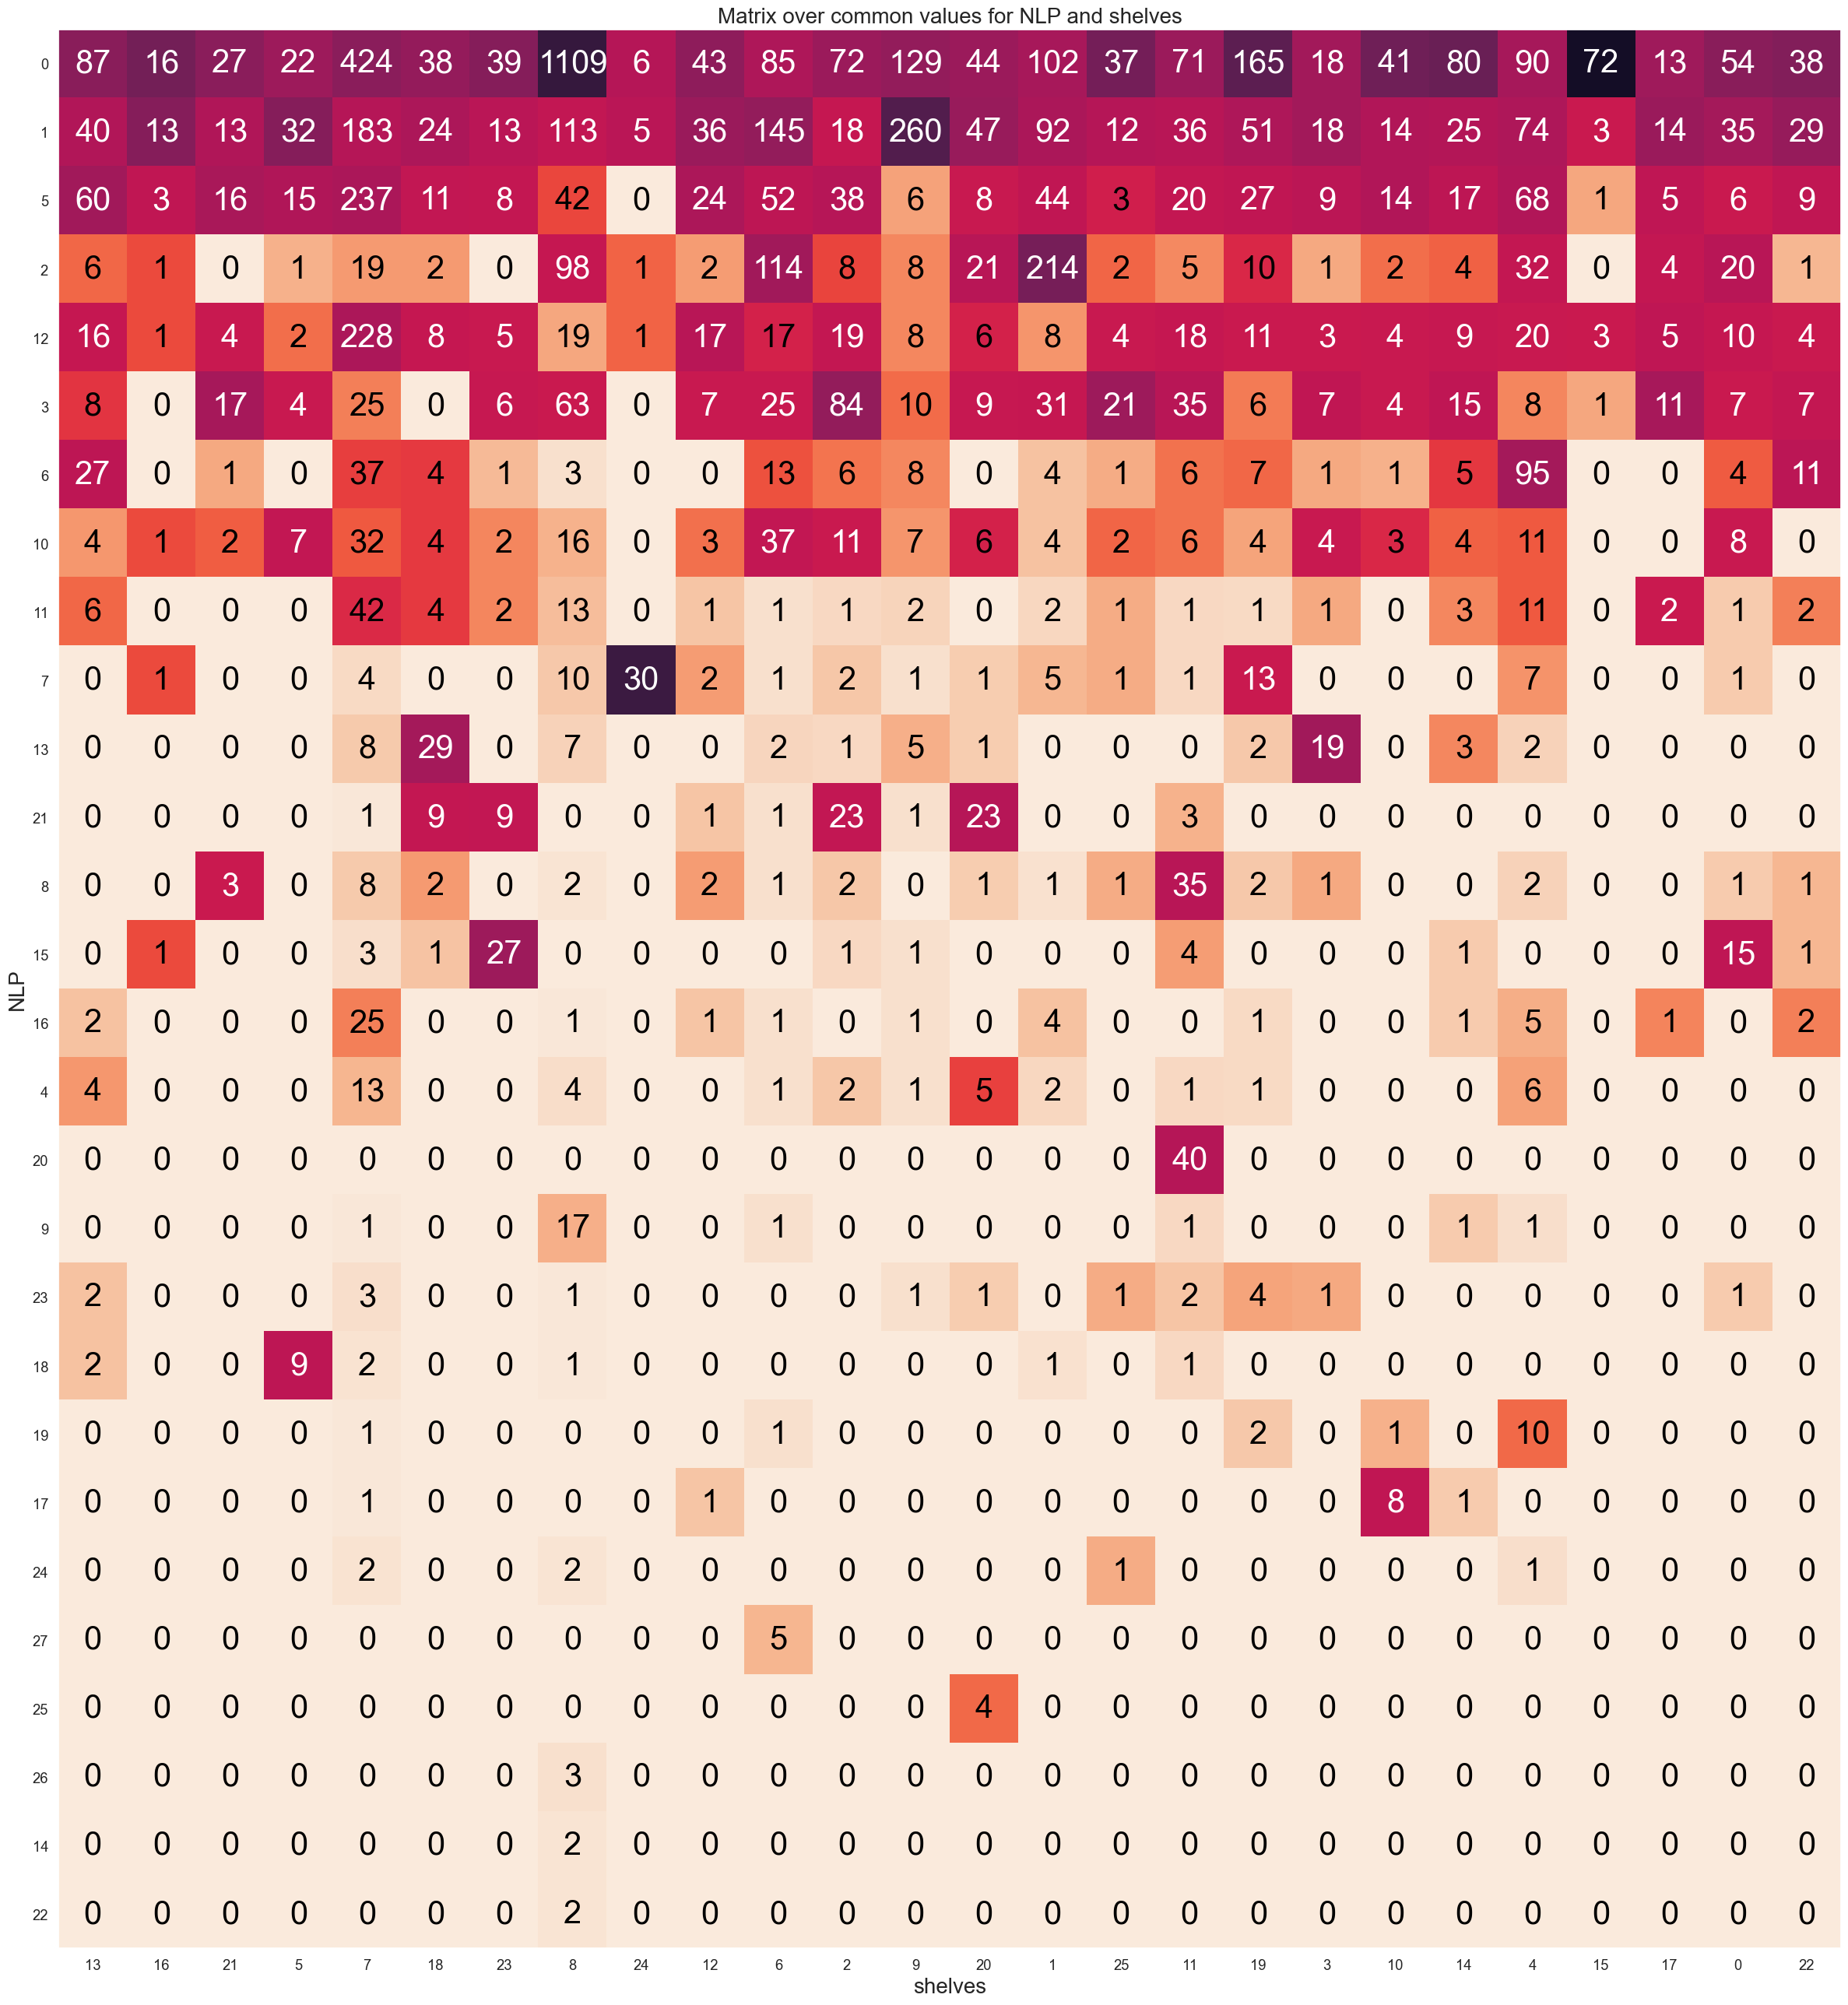

In [50]:
plot_matching_matrix(create_matching_matrix(shelf_community_mapping, NLP_community_mapping), title = "Matrix over common values for NLP and shelves", xlabel = "shelves", ylabel = "NLP",size_title = 20)
#TODO: i pycharm er 0 = brun, vscode 0=hvid

C:\Users\August\AppData\Local\Temp\ipykernel_24676\3670658498.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


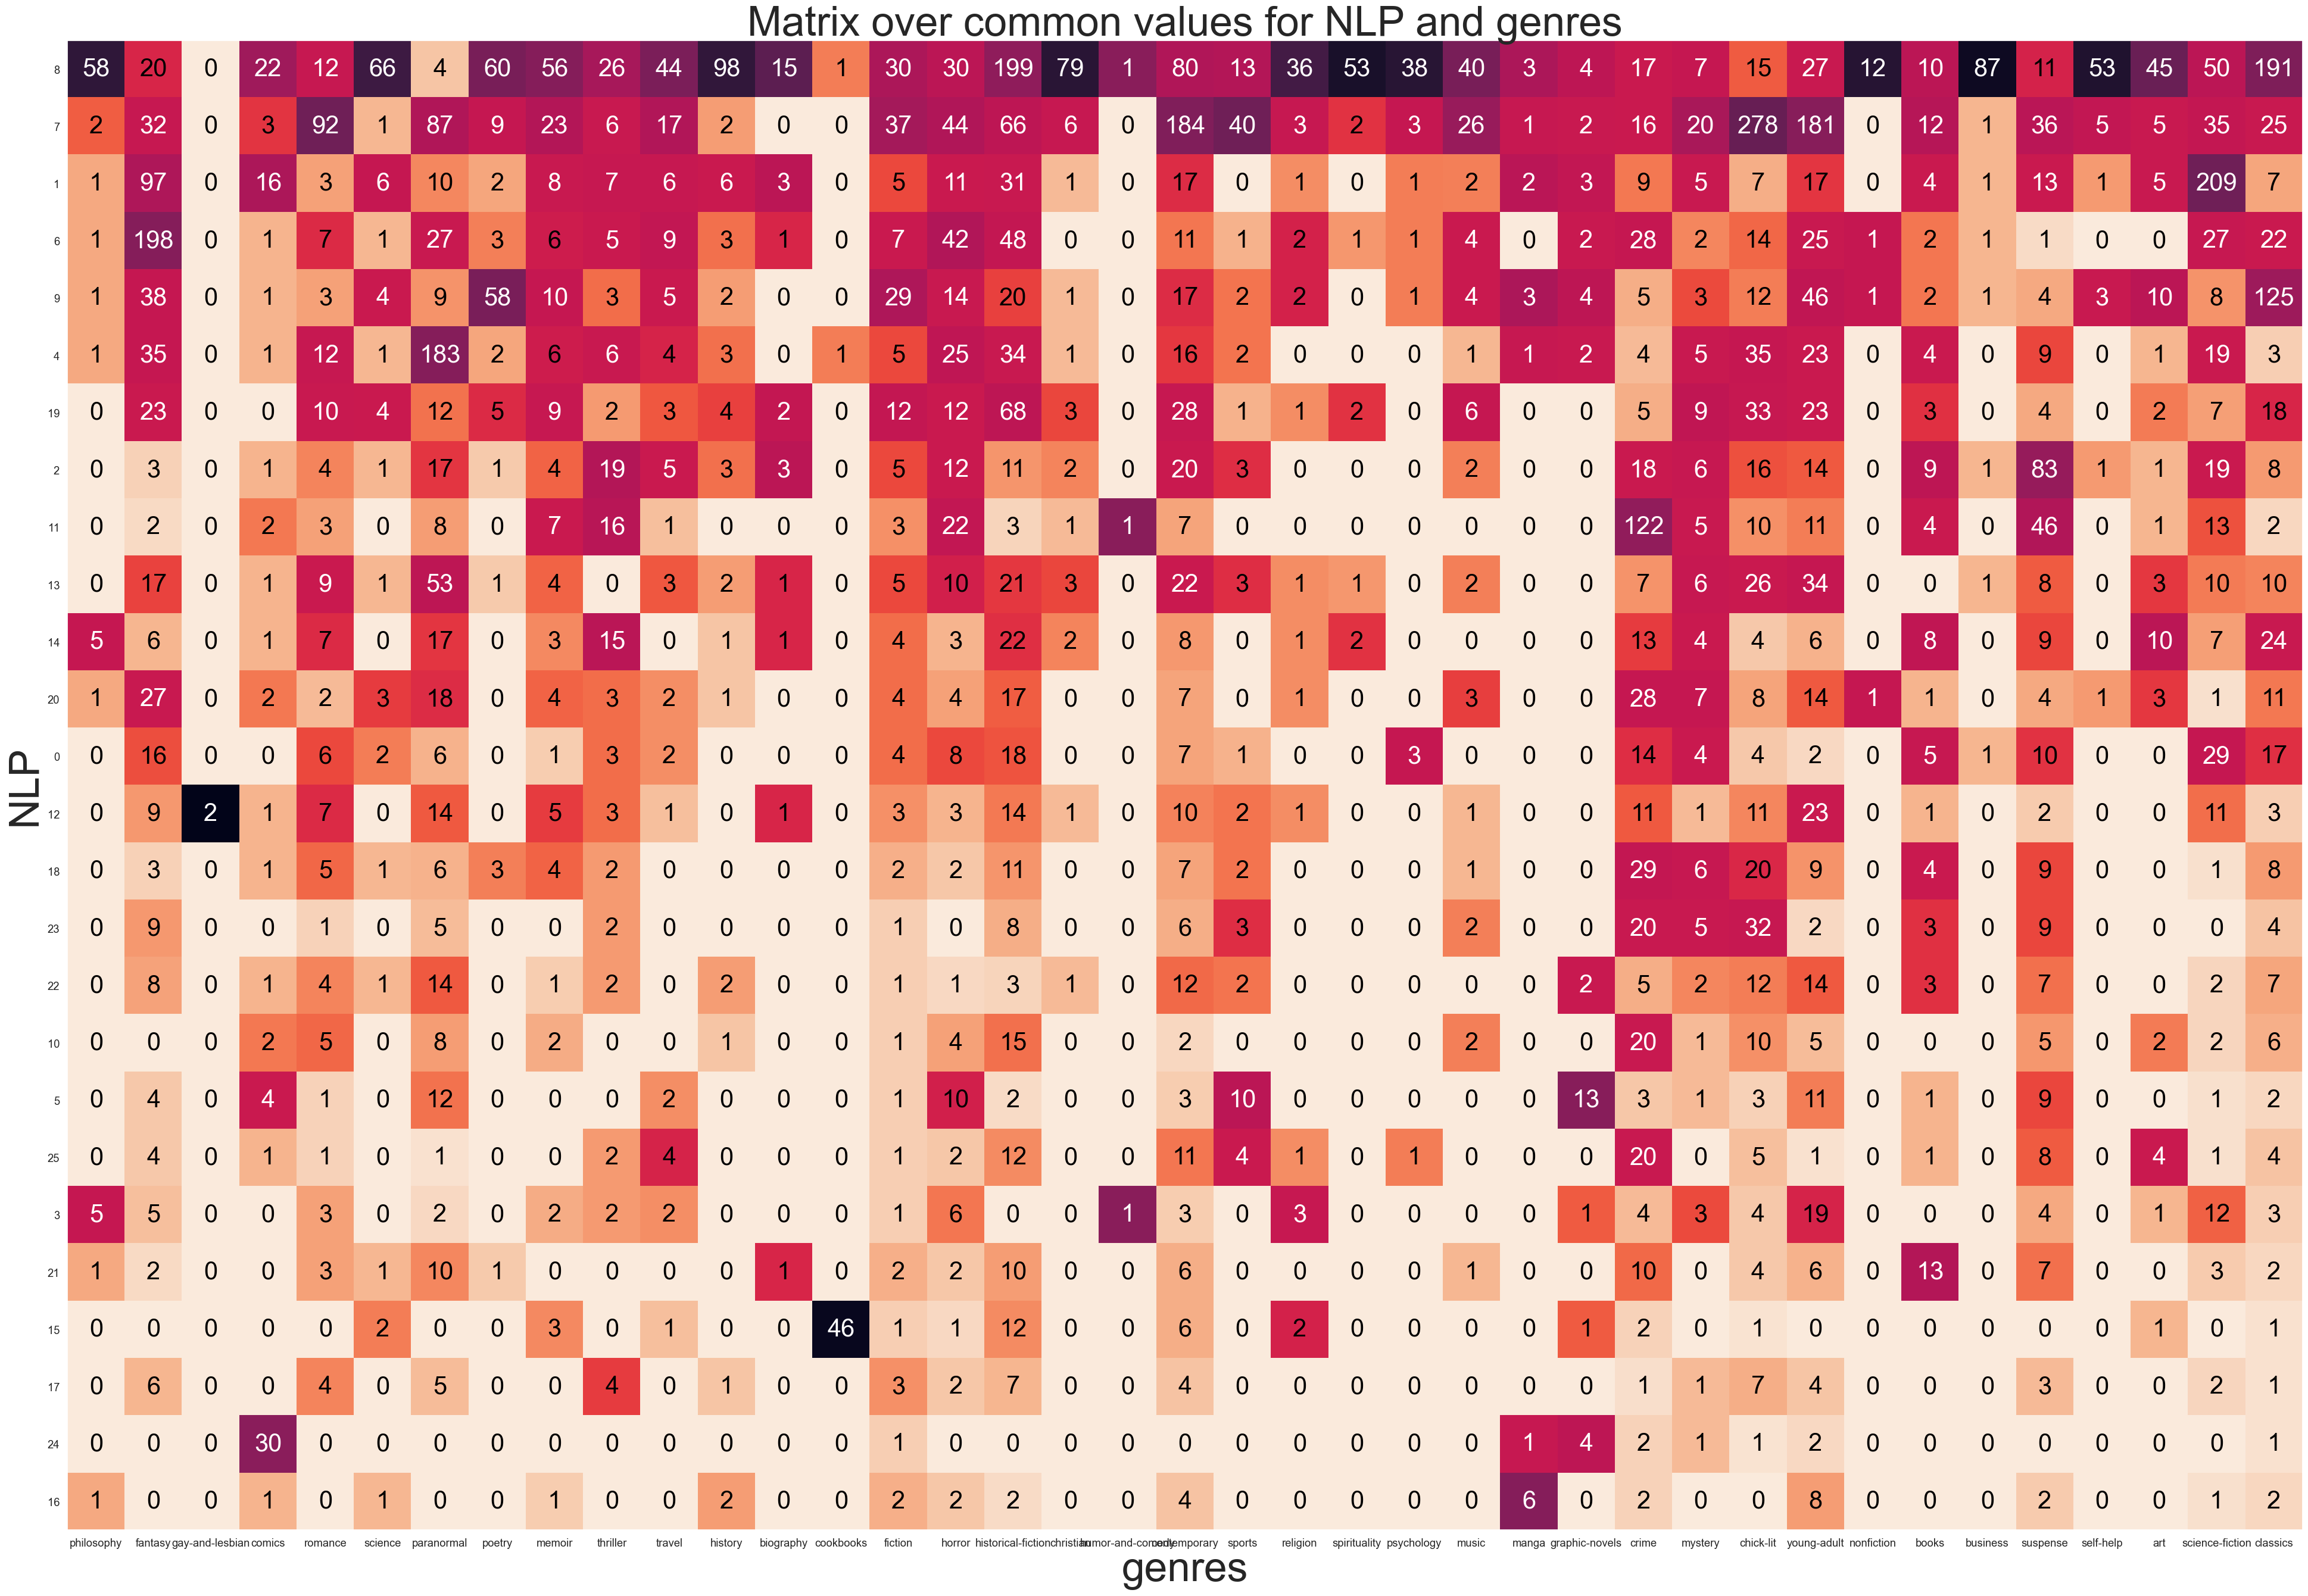

In [53]:
plot_matching_matrix(create_matching_matrix(NLP_community_mapping,book_genre_dict), title = "Matrix over common values for NLP and genres", xlabel = "genres", ylabel = "NLP",size_title = 50)

C:\Users\August\AppData\Local\Temp\ipykernel_24676\3670658498.py:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (col_name, col_data) in enumerate(matching_matrix.iteritems()):


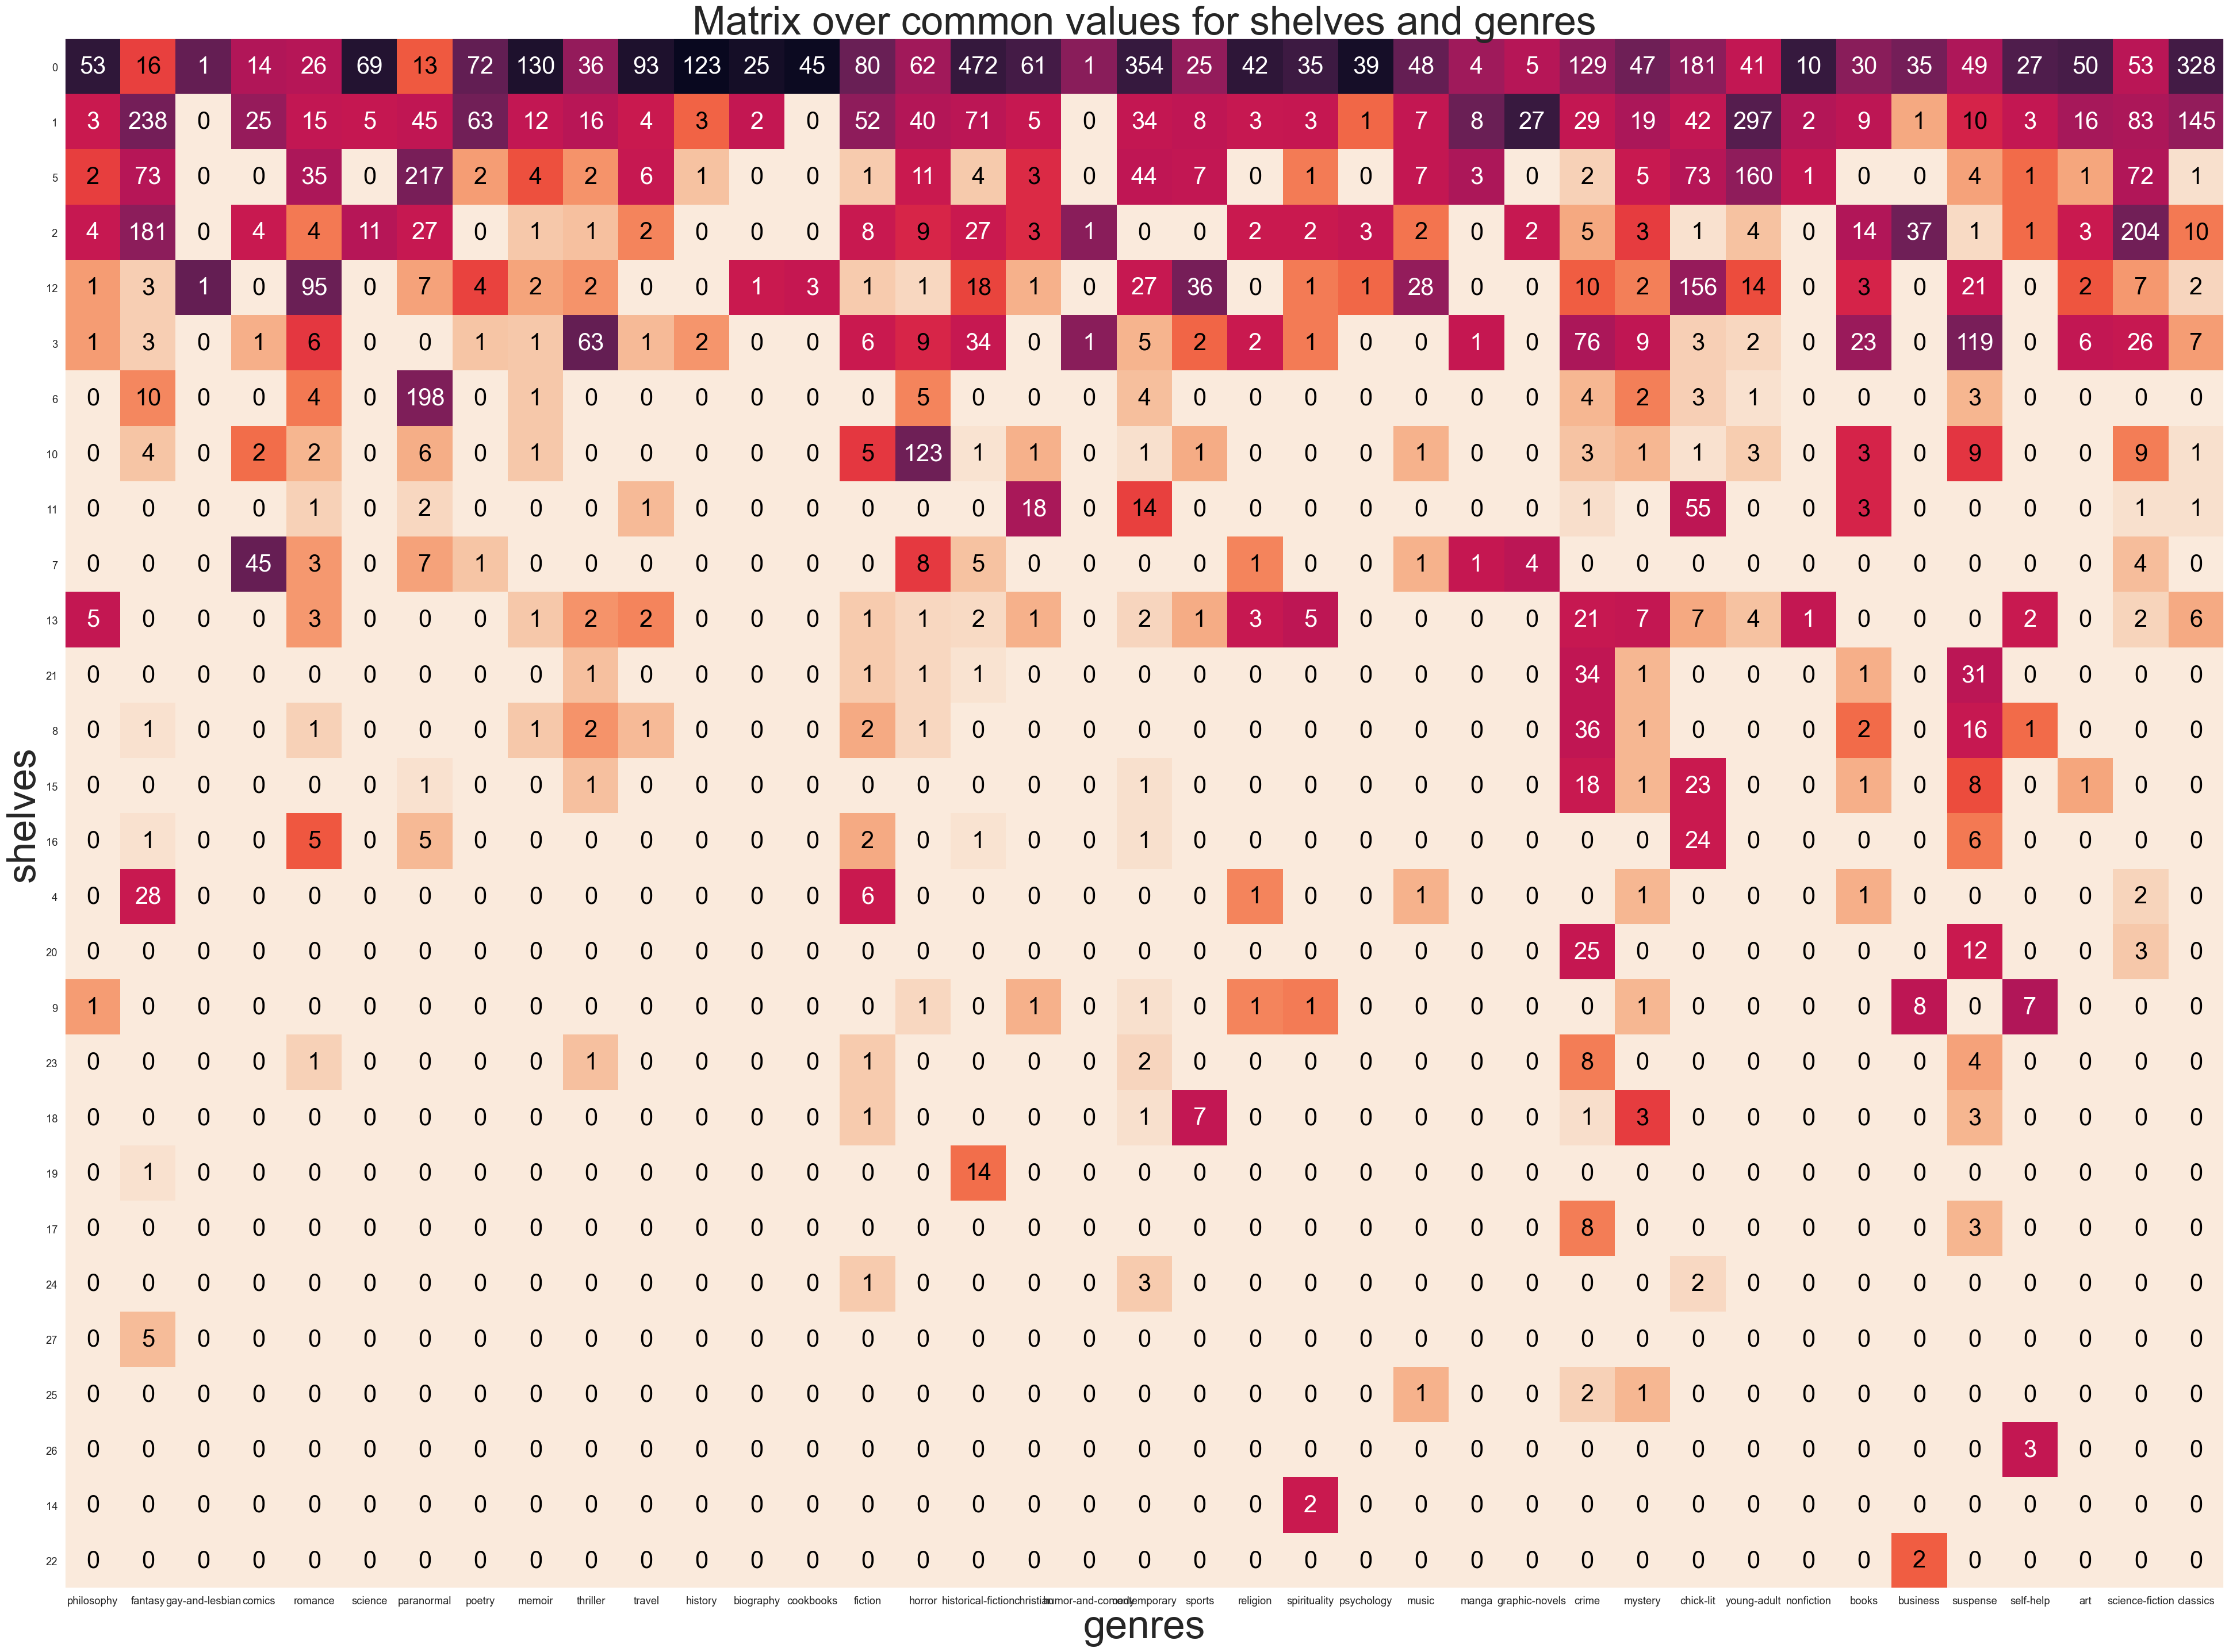

In [54]:
plot_matching_matrix(create_matching_matrix(shelf_community_mapping,book_genre_dict), title = "Matrix over common values for shelves and genres", xlabel = "genres", ylabel = "shelves",size_title = 50)

### Matching attributes

In [25]:
# Load graphs
if 'shelf_graph' not in locals():
    with open(DATA_PATH + 'shelves_network_05.pickle', 'rb') as f:
        shelf_graph = pickle.load(f)

if 'NLP_graph' not in locals():
    with open(DATA_PATH + 'NLP_network_05.pickle', 'rb') as f:
        NLP_graph = pickle.load(f)

    shelf_graph = make_all_nodes_ints(shelf_graph)
    NLP_graph = make_all_nodes_ints(NLP_graph)

In [46]:
print(f"(Shelf) The assortativity for genre is {nx.attribute_assortativity_coefficient(shelf_graph, 'top_genre'):.6f}, calculated with the mx library")

print(f"(NLP) The assortativity for genre is {nx.attribute_assortativity_coefficient(NLP_graph, 'top_genre'):.6f}, calculated with the mx library")

(Shelf) The assortativity for genre is -0.003799, calculated with the mx library
(NLP) The assortativity for genre is -0.000630, calculated with the mx library


### Is the graph assortative with respect to the degree?

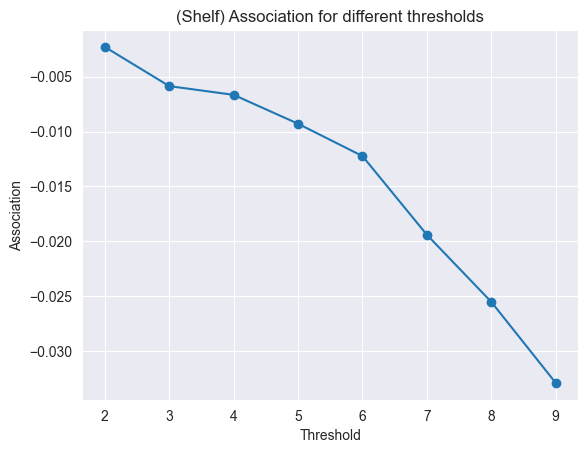

In [47]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 10
assosiations = np.zeros(max_threshold - 2)

for threshold in range(2, max_threshold):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in shelf_graph.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(shelf_graph.degree(edge[0]), threshold)
        j = get_i(shelf_graph.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*shelf_graph.number_of_edges())

    # Store the assosiation
    assosiations[threshold - 2] = calculate_assortiative_coef(E)

plt.plot(range(2, max_threshold), assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Association")
plt.title("(Shelf) Association for different thresholds")
plt.show()

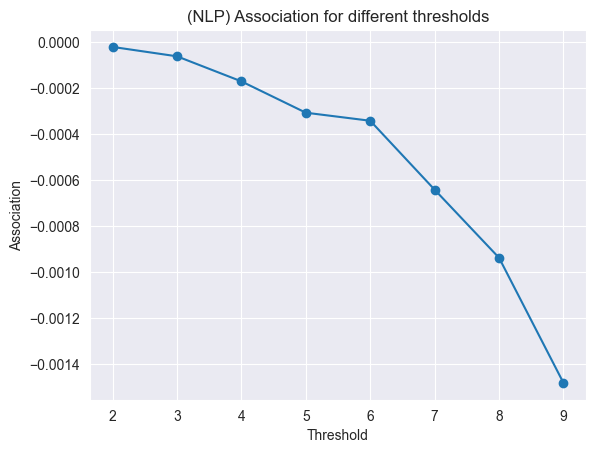

In [48]:
# Very similar to the function above, but this calculates the matrix for the degree instead of attribute
calculate_assortiative_coef = lambda E: (np.trace(E) - np.sum(E @ E.T)) / (1 - np.sum(E @ E.T))
get_i = lambda x, threshold: 1 if x > threshold else 0 # Small function to get the index of the matrix

max_threshold = 10
assosiations = np.zeros(max_threshold - 2)

for threshold in range(2, max_threshold):
    # Get dimensions of matrix
    E = np.zeros((2, 2))

    # Fill the matrix
    for edge in NLP_graph.edges:
        # Get the degree of the node at the ends of the edge
        i = get_i(NLP_graph.degree(edge[0]), threshold)
        j = get_i(NLP_graph.degree(edge[1]), threshold)
        E[i, j] += 1
        E[j, i] += 1

    E = E / (2*NLP_graph.number_of_edges())

    # Store the assosiation
    assosiations[threshold - 2] = calculate_assortiative_coef(E)

plt.plot(range(2, max_threshold), assosiations, "-o")
plt.xlabel("Threshold")
plt.ylabel("Association")
plt.title("(NLP) Association for different thresholds")
plt.show()

In [ ]:
# TODO: comment on plots

# Visualize graph

In [79]:
import netwulf
import ast

In [12]:
# Load graphs
shelf_graph = nx.read_graphml(DATA_PATH + 'shelves_graph_04.graphml')
shelf_graph = make_all_nodes_ints(shelf_graph)

NLP_graph = nx.read_graphml(DATA_PATH + 'NLP_graph_04.graphml')
NLP_graph = make_all_nodes_ints(NLP_graph)

#Load communities
shelf_louvain = np.load(DATA_PATH + 'shelves_communities_04.npy', allow_pickle = True)
NLP_louvain = np.load(DATA_PATH + 'NLP_communities_04.npy', allow_pickle= True)

In [80]:
if not "complete_book_df" in locals():
    complete_book_df = pd.read_csv(DATA_PATH + "complete_book_df.csv")

In [17]:
def make_attributes(df, graph):
    #TODO: args and returns
    # make a dictionary with attributes for each node
    book_attributes = dict()
    for i, book in tqdm(df.iterrows(), total=df.shape[0]):
        node = book['book_id']
        if not node in graph.nodes():
            continue
        book_attributes[node] = dict()
        top_genre = book['top_genre']
        title = book['title']
        genres = ast.literal_eval(book['genres'])

        book_attributes[node]['title'] = title
        book_attributes[node]['genres'] = genres
        book_attributes[node]['top_genre'] = top_genre
    return book_attributes

In [82]:
shelf_attribute_dict = make_attributes(complete_book_df, shelf_graph)
NLP_attribute_dict = make_attributes(complete_book_df, NLP_graph)

100%|██████████| 7676/7676 [00:00<00:00, 23929.70it/s]


In [83]:
nx.set_node_attributes(shelf_graph, shelf_attribute_dict)
nx.set_node_attributes(NLP_graph, NLP_attribute_dict)

In [16]:
import matplotlib.colors as mcolors
# List of colors to use for the visualization


# Use netwulf to visualize the communities
def visualize_communities(graph, communities):
    colors = list(mcolors.CSS4_COLORS.values())[20:len(communities) + 20]
    # Create a dictionary that maps nodes to communities
    node_to_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node = str(node)
            node_to_community[node] = i

    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_community[node]]

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_variation': 0.3,
                                    'zoom': 0.65,
                                    'scale_node_size_by_strength': True,})

In [64]:
visualize_communities(shelf_graph, shelf_louvain)

In [19]:
visualize_communities(NLP_graph, NLP_louvain)

### Colors for genre

In [24]:
def create_genre_dict(graph):
    genre_dict = {}
    for node in tqdm(graph.nodes):
        genre = nx.get_node_attributes(graph, 'top_genre')[node]
        try:
            genre_dict[genre].append(node)
        except:
            genre_dict[genre] = [node]
    return genre_dict

In [25]:
shelf_genre_dict = create_genre_dict(shelf_graph)
NLP_genre_dict = create_genre_dict(NLP_graph)

100%|██████████| 7671/7671 [00:12<00:00, 611.70it/s]


In [26]:
# Use netwulf to visualize the genres
def visualize_genres(graph, genre_dict):
    colors = list(mcolors.CSS4_COLORS.values())[20:len(genre_dict.keys())+20]
    # Create a dictionary that maps nodes to genre
    node_to_genre = {}
    for i, genre in enumerate(genre_dict.keys()):
        for node in genre_dict[genre]:
            node_to_genre[node] = i



    # Add a color attribute to the nodes
    for node in graph.nodes:
        # Add the community number as a node attribute
        graph.nodes[node]["color"] = colors[node_to_genre[node]]

    # Visualize the graph with netwulf
    netwulf.visualize(graph, config={"Node color": "color",
                                    'node_size': 50,
                                    'link_width': 0.1,
                                    'link_alpha': 0.01,
                                    'node_size_variation': 0.3,
                                    'zoom': 0.65,
                                    'scale_node_size_by_strength': True,})

In [62]:
visualize_genres(shelf_graph, shelf_genre_dict)

In [27]:
visualize_genres(NLP_graph, NLP_genre_dict)

# Generate wordclouds

In [30]:
# Find top three books for each community according to degree
def get_top_3_books(graph_type, louvain_groups):
    top_3_books = {}
    # Store the top 3 books by degree for all communities
    for i, community in enumerate(louvain_groups):

        # Get the top 3 books by degree
        sorted_dict = sorted(dict(graph_type.degree(community)).items(), key=lambda x: x[1], reverse=True)
        names = nx.get_node_attributes(graph_type, "title")
        top_3_keys = [k for k, v in sorted_dict[:3]] # Get the ID
        top_3_names = [names[k] for k in top_3_keys] # get the name

        top_3_books[i] = [(top_3_keys[j], top_3_names[j]) for j in range(len(top_3_keys))]
        return top_3_books

Shelf graph
**********
1. largest community 1: 
Book: the hunger games, degree: 7312
Book: to kill a mockingbird, degree: 6527
Book: catching fire, degree: 5683

2. largest community 0: 
Book: harry potter and the chamber of secrets, degree: 5694
Book: harry potter and the prisoner of azkaban, degree: 5530
Book: harry potter and the deathly hallows, degree: 5394

3. largest community 5: 
Book: eclipse, degree: 2309
Book: breaking dawn, degree: 2232
Book: city of bones, degree: 1947

4. largest community 3: 
Book: angels & demons, degree: 1024
Book: a time to kill, degree: 151
Book: along came a spider, degree: 145

5. largest community 2: 
Book: the riddle, degree: 1384
Book: a wrinkle in time, degree: 771
Book: charlotte's web, degree: 657

6. largest community 9: 
Book: fifty shades of grey, degree: 890
Book: beautiful disaster, degree: 496
Book: fifty shades darker, degree: 399

7. largest community 6: 
Book: dark lover, degree: 498
Book: dead until dark, degree: 405
Book: halfway t

In [36]:
shelf_int_graph = make_all_nodes_ints(shelf_graph)

In [25]:
shelf_top_3_books = get_top_3_books(shelf_int_graph, shelf_louvain)
